In [ ]:
#polars 
!pip install polars

In [39]:
# Импорт необходимых библиотек
import pandas as pd
import polars as pl
import plotly.express as px

In [41]:
# --- Загрузка данных ---
train_q = pl.scan_csv('train.csv')
lectures_q = pl.scan_csv('lectures.csv')
questions_q = pl.scan_csv('questions.csv')

In [45]:
# схемa большого файла
schema = train_q.collect_schema()
print(schema)

Schema({'row_id': Int64, 'timestamp': Int64, 'user_id': Int64, 'content_id': Int64, 'content_type_id': Int64, 'task_container_id': Int64, 'user_answer': Int64, 'answered_correctly': Int64, 'prior_question_elapsed_time': Float64, 'prior_question_had_explanation': Boolean})


In [47]:
# первые 5 элементов
train_head = train_q.head(5).collect()

print(train_head)

shape: (5, 10)
┌────────┬───────────┬─────────┬────────────┬───┬────────────┬────────────┬────────────┬───────────┐
│ row_id ┆ timestamp ┆ user_id ┆ content_id ┆ … ┆ user_answe ┆ answered_c ┆ prior_ques ┆ prior_que │
│ ---    ┆ ---       ┆ ---     ┆ ---        ┆   ┆ r          ┆ orrectly   ┆ tion_elaps ┆ stion_had │
│ i64    ┆ i64       ┆ i64     ┆ i64        ┆   ┆ ---        ┆ ---        ┆ ed_time    ┆ _explanat │
│        ┆           ┆         ┆            ┆   ┆ i64        ┆ i64        ┆ ---        ┆ ion       │
│        ┆           ┆         ┆            ┆   ┆            ┆            ┆ f64        ┆ ---       │
│        ┆           ┆         ┆            ┆   ┆            ┆            ┆            ┆ bool      │
╞════════╪═══════════╪═════════╪════════════╪═══╪════════════╪════════════╪════════════╪═══════════╡
│ 0      ┆ 0         ┆ 115     ┆ 5692       ┆ … ┆ 3          ┆ 1          ┆ null       ┆ null      │
│ 1      ┆ 56943     ┆ 115     ┆ 5716       ┆ … ┆ 2          ┆ 1          ┆ 

In [49]:
#Фильтрация данных: только вопросы
train_q_quest = train_q.filter( pl.col('content_type_id') == 0)

In [51]:
# --- Числовая статистика ---
train_full = (train_q_quest.select(
    # выбираем все нужные столбцы
    pl.all().exclude('row_id', 'content_type_id', 'user_id', 'content_id', 'user_answer', 'task_container_id', 'prior_question_had_explanation'),
    pl.col('prior_question_had_explanation').cast(pl.Float32)  # столбец с булевым > число
).collect(streaming=True))

In [53]:
print(train_full.describe())  # Проверяем что работает

shape: (9, 5)
┌────────────┬─────────────┬────────────────────┬─────────────────────────┬────────────────────────┐
│ statistic  ┆ timestamp   ┆ answered_correctly ┆ prior_question_elapsed_ ┆ prior_question_had_exp │
│ ---        ┆ ---         ┆ ---                ┆ time                    ┆ lanation               │
│ str        ┆ f64         ┆ f64                ┆ ---                     ┆ ---                    │
│            ┆             ┆                    ┆ f64                     ┆ f64                    │
╞════════════╪═════════════╪════════════════════╪═════════════════════════╪════════════════════════╡
│ count      ┆ 9.92713e7   ┆ 9.92713e7          ┆ 9.8878794e7             ┆ 9.8878794e7            │
│ null_count ┆ 0.0         ┆ 0.0                ┆ 392506.0                ┆ 392506.0               │
│ mean       ┆ 7.7021e9    ┆ 0.657236           ┆ 25423.810043            ┆ 0.907025               │
│ std        ┆ 1.1595e10   ┆ 0.474634           ┆ 19948.146709            ┆ 0

мы видим что 65~66% вопросов получили верные ответы, в 91% случаев учащиеся знакомились с объяснением

In [55]:
#первые 5 элементов файлов с информацией о вопросах и лекциях
lectures_head = lectures_q.head(5).collect()
questions_head = questions_q.head(5).collect()
print(lectures_head)
print(questions_head)

shape: (5, 4)
┌────────────┬─────┬──────┬──────────────────┐
│ lecture_id ┆ tag ┆ part ┆ type_of          │
│ ---        ┆ --- ┆ ---  ┆ ---              │
│ i64        ┆ i64 ┆ i64  ┆ str              │
╞════════════╪═════╪══════╪══════════════════╡
│ 89         ┆ 159 ┆ 5    ┆ concept          │
│ 100        ┆ 70  ┆ 1    ┆ concept          │
│ 185        ┆ 45  ┆ 6    ┆ concept          │
│ 192        ┆ 79  ┆ 5    ┆ solving question │
│ 317        ┆ 156 ┆ 5    ┆ solving question │
└────────────┴─────┴──────┴──────────────────┘
shape: (5, 5)
┌─────────────┬───────────┬────────────────┬──────┬────────────────┐
│ question_id ┆ bundle_id ┆ correct_answer ┆ part ┆ tags           │
│ ---         ┆ ---       ┆ ---            ┆ ---  ┆ ---            │
│ i64         ┆ i64       ┆ i64            ┆ i64  ┆ str            │
╞═════════════╪═══════════╪════════════════╪══════╪════════════════╡
│ 0           ┆ 0         ┆ 0              ┆ 1    ┆ 51 131 162 38  │
│ 1           ┆ 1         ┆ 1            

In [57]:
# зависимость правильных ответов от получения разъяснений на предыдущий вопрос
print(
    train_q_quest.select(
        pl.col('prior_question_had_explanation'),
        pl.col('answered_correctly'),
    ).drop_nulls()
    .group_by('prior_question_had_explanation')
    .agg(
        pl.col('answered_correctly')
        .mean()
    ).collect(streaming=True)
)

shape: (2, 2)
┌────────────────────────────────┬────────────────────┐
│ prior_question_had_explanation ┆ answered_correctly │
│ ---                            ┆ ---                │
│ bool                           ┆ f64                │
╞════════════════════════════════╪════════════════════╡
│ false                          ┆ 0.500629           │
│ true                           ┆ 0.673189           │
└────────────────────────────────┴────────────────────┘


In [ ]:
видим что результат улучшается на 10% если обьяснение было

In [81]:
# как часто учащиеся получали разъяснения
print(
    train_q_quest.select(
        # в столбце с разъяснениями возьмем все элементы, кроме первого
        pl.col('prior_question_had_explanation').slice(1, None),
        # в столбце с ответами возьмем все элементы, кроме последнего
        pl.col('answered_correctly').slice(0, pl.col('answered_correctly').count() - 1)
    # сгруппируем данные по столбцу ответа
    ).group_by('answered_correctly')
    # для стобца факта разъяснений проведем аггрегацию
    .agg(
        pl.col('prior_question_had_explanation')
        # приводим булево к числу
        .cast(pl.Float32)
        # вычисляем среднее
        .mean()
        # так как смысл столбца поменялся, переименуем его
        .alias('_had_explanation')
    # обработка со стримингом
    ).collect(streaming=True)
)

shape: (2, 2)
┌────────────────────┬──────────────────┐
│ answered_correctly ┆ _had_explanation │
│ ---                ┆ ---              │
│ i64                ┆ f64              │
╞════════════════════╪══════════════════╡
│ 0                  ┆ 0.86446          │
│ 1                  ┆ 0.929161         │
└────────────────────┴──────────────────┘


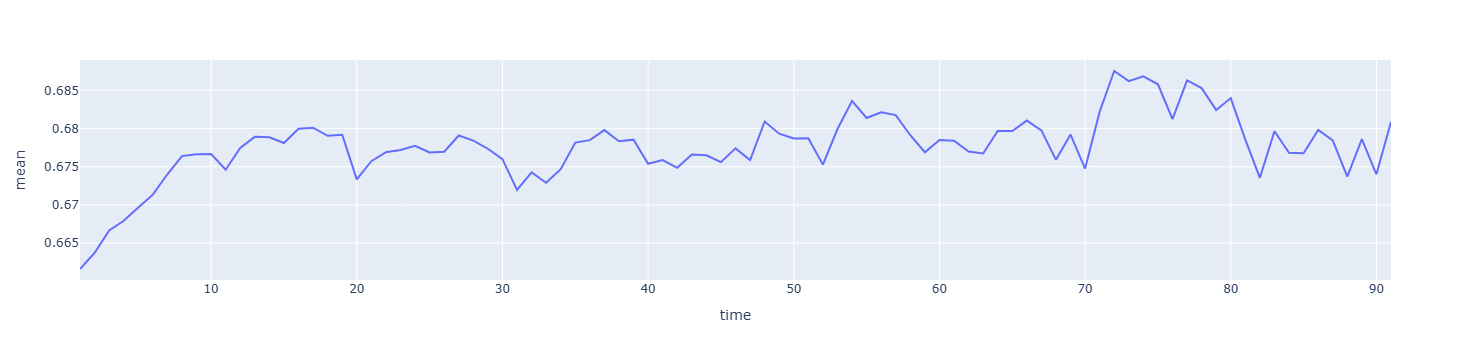

In [83]:
# --- Влияние времени на вопросы ---
result = ((train_q_quest.filter(
    # отрезаем выбросы выше 90-го перцентиля
    (pl.col('timestamp') < pl.col('timestamp').quantile(0.9)) &
    # отрезаем выбросы ниже относительно малого значения
    (pl.col('timestamp') > 300000000)
).group_by(
    # группируем данные по времени, сгладив результаты
    (pl.col('timestamp') // 250000000).alias('time'),
).agg(
    # для аггрегации возьмем среднее количество правильных ответов
    pl.col('answered_correctly').mean().alias('mean'),
# отсортируем по времени
)).sort('time')
          .collect(streaming=True))

# линейный график
px.line(result, x='time', y='mean', )

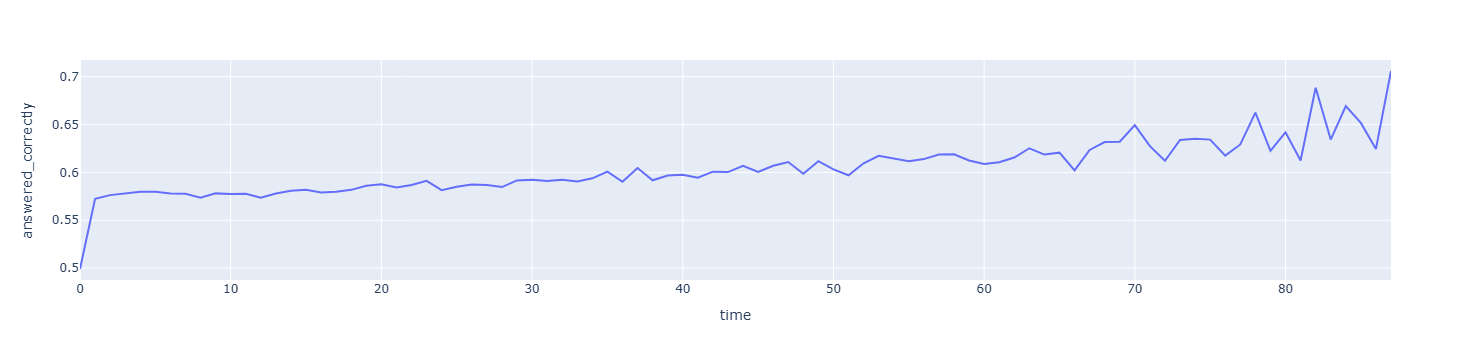

In [85]:
#как зависит среднее количество правильных ответов от полного времени обучения
# группируем данные по пользователям
result = (train_q.group_by(
    pl.col('user_id')
# посчитаем необходимые аггрегаты
).agg(
    # количество строк
    pl.col('row_id').count(),
    # макимальное значение времени
    pl.col('timestamp').max().alias('time'),
    # среднее количество правильных ответов
    pl.col('answered_correctly').mean(),
).filter(
    # уберем из выборки результаты с малым количеством строк
    pl.col('row_id') > pl.col('row_id').quantile(0.1)
).group_by(
    # группируем по сглаженному времени
    pl.col('time') // 1000000000
).agg(
    # аггрегируем среднее по правильным ответам
    pl.col('answered_correctly').mean()
).sort('time')
          .collect(streaming=True))


px.line(result, x='time', y='answered_correctly')

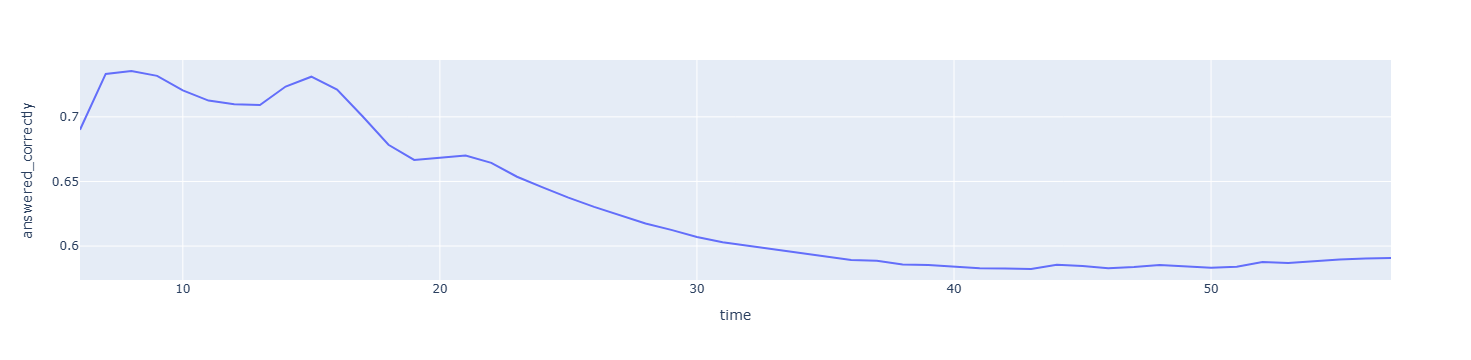

In [86]:
#зависимость правильных ответов от затраченного на вопрос времени
result = ((train_q.filter(
    # отбросим слишком большие значения времени
    (pl.col('prior_question_elapsed_time') < pl.col('prior_question_elapsed_time').quantile(0.95)) &
    # отбросим слишком малые значения времени
    (pl.col('prior_question_elapsed_time') > pl.col('prior_question_elapsed_time').quantile(0.05))
).select(
    # для соответствия столбцов делаем сдвиг
    pl.col('prior_question_elapsed_time').slice(1, None),
    pl.col('answered_correctly').slice(0, pl.col('answered_correctly').count() - 1)
).group_by(
    # группируем по сглаженному до секунд времени
    (pl.col('prior_question_elapsed_time') // 1000).alias('time')
# считаем среднее количество правильных ответов
).agg(pl.col('answered_correctly').mean()))
          .sort(pl.col('time'))
          .collect(streaming=True))


px.line(result, x='time', y='answered_correctly')

после 15 секунд, среднее количество правильных ответов резко снижается

In [88]:
# dataframe join
quest_joined_q = (train_q_quest.join(questions_q, left_on='content_id', right_on='question_id', how='left'))
# в столбце tag данные преобразовываем в список
quest_joined_split_q = quest_joined_q.with_columns(
    pl.col('tags').str.split(" ")
)

In [89]:
# берем из dataframe столбцы с тэгами и правильностью ответов
quest_joined_expl_q = (quest_joined_split_q.select(
    pl.col('answered_correctly'),
    pl.col('tags'),
# разбиваем столбец с тэгами на отдельные строки
).explode('tags')
# группируем по тэгу
.group_by(
    pl.col('tags').alias('tag')
).agg(
    # считаем среднее количество правильных ответов
    pl.col('answered_correctly').mean().alias('mean'),
).drop_nulls()
# и сортируем по нему
.sort('mean'))

print(quest_joined_expl_q.collect(streaming=True))

shape: (188, 2)
┌─────┬──────────┐
│ tag ┆ mean     │
│ --- ┆ ---      │
│ str ┆ f64      │
╞═════╪══════════╡
│ 24  ┆ 0.385725 │
│ 23  ┆ 0.438487 │
│ 19  ┆ 0.439938 │
│ 151 ┆ 0.493155 │
│ 167 ┆ 0.500432 │
│ …   ┆ …        │
│ 40  ┆ 0.813804 │
│ 149 ┆ 0.848015 │
│ 130 ┆ 0.853152 │
│ 187 ┆ 0.85602  │
│ 68  ┆ 0.863945 │
└─────┴──────────┘


вопросы с тэгом=24 получено 38.6% правильных ответов, вопросы с тэгом=68 более 86% (можно предположить сложность)

In [91]:
# берем из датафрэйма столбцы с темами и правильностью ответов
quest_joined_expl_q = (quest_joined_split_q.select(
    pl.col('answered_correctly'),
    pl.col('part'),
# группируем по разделу
).group_by(
    pl.col('part')
).agg(
    # считаем среднее количество правильных ответов
    pl.col('answered_correctly').mean().alias('mean'),
).drop_nulls()
                       # и сортируем по нему
                       .sort('mean'))

print(quest_joined_expl_q.collect(streaming=True))

shape: (7, 2)
┌──────┬──────────┐
│ part ┆ mean     │
│ ---  ┆ ---      │
│ i64  ┆ f64      │
╞══════╪══════════╡
│ 5    ┆ 0.610088 │
│ 4    ┆ 0.630998 │
│ 7    ┆ 0.659601 │
│ 6    ┆ 0.669388 │
│ 3    ┆ 0.701456 │
│ 2    ┆ 0.708694 │
│ 1    ┆ 0.745032 │
└──────┴──────────┘


вопросы с темой=5 получено 61% правильных ответов, вопросы с темой=1 более 74% (можно предположить сложность)

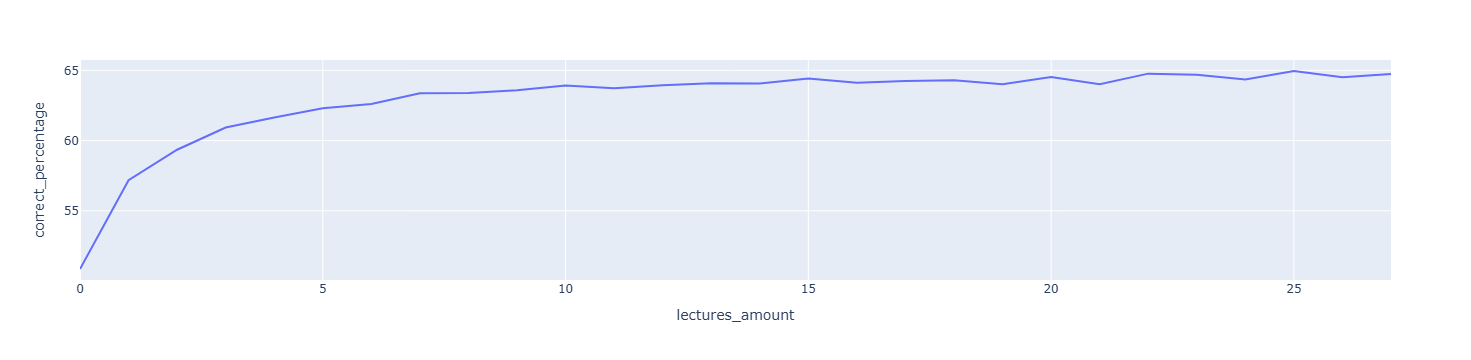

In [93]:
# группируем данные по пользователям
result = (train_q.group_by('user_id')
    # посчитаем необходимые аггрегаты
.agg(
    # количество строк
    pl.col('row_id').count().alias('rows'),
    # количество лекций
    (pl.col('content_type_id') == 1).sum().alias('lectures_amount'),
    # количество вопросов
    (pl.col('content_type_id') == 0).sum().alias('questions'),
    # количество правильных ответов
    (pl.col('answered_correctly') == 1).sum().alias('correct'),
).filter(
    # уберем из выборки результаты с малым количеством строк
    (pl.col('rows') > pl.col('rows').quantile(0.1)) &
    # Отсечем выбросы с количеством лекций
    (pl.col('lectures_amount') < pl.col('lectures_amount').quantile(0.95))
# отбираем колонки для дальнейшего анализа
).select(
    # количество лекций
    pl.col('lectures_amount'),
    # считаем процент правильных ответов
    (pl.col('correct') / pl.col('questions') * 100).alias('correct_percentage')
).group_by(
    # группируем по количеству лекций
    pl.col('lectures_amount')
).agg(
    # аггрегируем среднее по правильным ответам
    pl.col('correct_percentage').mean()
).sort('lectures_amount')
          .collect(streaming=True))
# строим график
px.line(result, x='lectures_amount', y='correct_percentage')

Meaning: чем больше просещенных лекций тем выше оценка